# 50.039 Deep Learning
### Group 19 - Inertial-Based Real-Time Human Action Recognition For Physiotherapy

Human kinetic analysis through automated interpretation of movement data has grown as an important application of deep learning. Models trained on data from wearable sensors and other modalities have shown potential for gaining meaningful insights into human biomechanics, activities, and performance over time. Deep learning has demonstrated potential in applications such as motion capture, action recognition and rehabilitation monitoring.

In this project, we sought to develop a physical therapy exercise classifier using inertial sensor data from the PHYTMO (PHYsical Therapy MOnitoring) dataset [1], which contains inertial measurement unit (IMU) sensor recordings of common physical therapy exercises .

## Imports

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader

from src.Dataset import CustomDataset
from src.create_dataset import generate_datasets
from src.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from src.TestHelpers import test_model, calculate_accuracy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


## Download and Extract Raw Data

The dataset can be downloaded from the following URL: https://zenodo.org/records/6319979/files/PHYTMO.zip?download=1

Please unzip the folder contents into the provided 'input' folder, as shown:

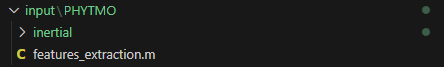

Else, replace the path in the cell below with the path of the extracted data.

In [3]:
RAW_DATASET_DIR = os.path.join(".", "input", "PHYTMO")

## Preprocess and Generate Dataset

The following function is imported from src/create_datasets.py. If required, replace the 
Its function is to extract only the data we want to use from the Raw Dataset, as well as preprocess it with the following operations:

1. Trimming to remove 'Dead' data at the start and end of each file
2. Downsampling to 20Hz
3. Min-Max Scaling
4. 'Windowed' into 3 second segments at intervals of 0.5 seconds
5. Split into Train, Test and Val sets in a 7:2:1 Ratio

The generated files will be stored in the 'input' folder.

In [4]:
# generate_datasets(RAW_DATASET_DIR)

## Load and Check Data

(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


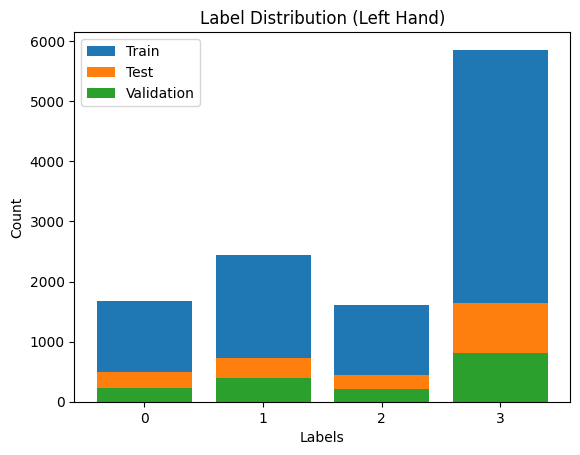

In [5]:
dataset_ver = '3w05s_Larm'

# Load Data
x_train_L = np.load(f'input/train_data_{dataset_ver}.npy')
x_val_L = np.load(f'input/val_data_{dataset_ver}.npy')
x_test_L = np.load(f'input/test_data_{dataset_ver}.npy')

y_train_L = np.load(f'input/train_labels_{dataset_ver}.npy')
y_val_L = np.load(f'input/val_labels_{dataset_ver}.npy')
y_test_L = np.load(f'input/test_labels_{dataset_ver}.npy')

# Create Datasets and Dataloaders
train_dataset_L = CustomDataset("train", dataset_ver)
train_dataloader_L = DataLoader(train_dataset_L, batch_size=16, shuffle=True)
val_dataset_L = CustomDataset("val", dataset_ver)
val_dataloader_L = DataLoader(val_dataset_L, batch_size=16, shuffle=True)
test_dataset_L = CustomDataset("test", dataset_ver)
test_dataloader_L = DataLoader(test_dataset_L, batch_size=16, shuffle=True)

# Check Dataset
print(x_train_L.shape, x_test_L.shape, x_val_L.shape)
unique_labels_train, label_counts_train = np.unique(y_train_L, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val_L, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test_L, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution (Left Hand)')
plt.legend()
plt.show()

(11582, 60, 9)

 (3310, 60, 9) (1655, 60, 9)


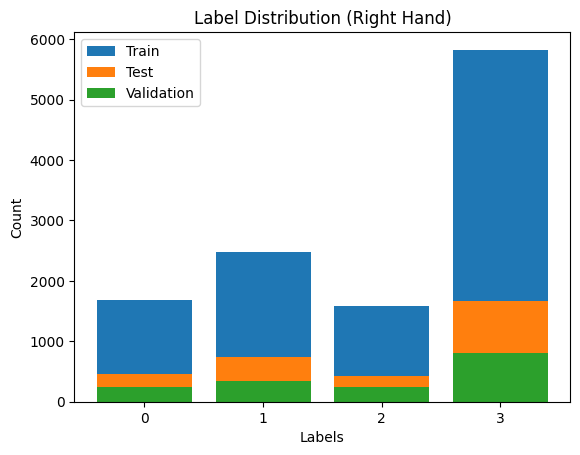

In [6]:
dataset_ver = '3w05s_Rarm'

# Load Data
x_train_R = np.load(f'input/train_data_{dataset_ver}.npy')
x_val_R = np.load(f'input/val_data_{dataset_ver}.npy')
x_test_R = np.load(f'input/test_data_{dataset_ver}.npy')

y_train_R = np.load(f'input/train_labels_{dataset_ver}.npy')
y_val_R = np.load(f'input/val_labels_{dataset_ver}.npy')
y_test_R = np.load(f'input/test_labels_{dataset_ver}.npy')

# Create Datasets and Dataloaders
train_dataset_R = CustomDataset("train", dataset_ver)
train_dataloader_R = DataLoader(train_dataset_R, batch_size=16, shuffle=True)
val_dataset_R = CustomDataset("val", dataset_ver)
val_dataloader_R = DataLoader(val_dataset_R, batch_size=16, shuffle=True)
test_dataset_R = CustomDataset("test", dataset_ver)
test_dataloader_R = DataLoader(test_dataset_R, batch_size=16, shuffle=True)

# Check Dataset
print(x_train_R.shape, x_test_R.shape, x_val_R.shape)
unique_labels_train, label_counts_train = np.unique(y_train_R, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val_R, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test_R, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution (Right Hand)')
plt.legend()
plt.show()

## Solution

The following contains code for our best performing model, as well as the code to train it. The model weights are also available for direct loading if preferred. All other model variations for testing are included in notebooks/training.

### Model

Our best performing model is first training a CNN-LSTM Autoencoder with 1 CNN Layer followed by 1 LSTM Layer. The CNN layer uses 64 3-by-3 kernels with a padding of 1. The LSTM Layer is a unidirectional LSTM with a hidden size of 360. Finally, a dropout layer is included with a ratio of 0.2.

In [7]:
# 1- Layer CNN + 1-Layer Unidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(input_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        nb_filters = 64
        self.hidden_size = hidden_size
        self.conv = nn.Conv1d(hidden_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

Two models are trained for ease of use at inference time: Each IMU can stream data to its own model for prediction. For demonstration purposes in this notebook, and in the interest of time, the Right Hand model is omitted.

In [8]:
n_input = 9
n_hidden = 360
num_epochs = 50
dropout_rate = 0.2
lr_rate = 1e-3
early_stop = 5

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0403, Val Loss: 0.0428
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0298, Val Loss: 0.0271
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0182, Val Loss: 0.0192
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0154, Val Loss: 0.0162
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0123, Val Loss: 0.0145
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0171, Val Loss: 0.0121
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0114, Val Loss: 0.0121
ES_Counter: 1
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0162, Val Loss: 0.0127
ES_Counter: 2
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0131, Val Loss: 0.0103
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0114, Val Loss: 0.0107
ES_Counter: 1
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0090, Val Loss: 0.0105
ES_Counter: 2
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0110, Val Loss: 0.0101
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0119, Val Loss: 0.0097
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0099, Val Loss: 0.0089
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0121, Val Loss: 0.0085
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0088, Val Loss: 0.0089
ES_Counter: 1
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0146, Val Loss: 0.0083
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0079, Val Loss: 0.0090
ES_Counter: 1
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0083, Val Loss: 0.0082
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0072, Val Loss: 0.0086
ES_Counter: 1
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0103, Val Loss: 0.0084
ES_Counter: 2
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0097, Val Loss: 0.0075
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0091, Val Loss: 0.0072
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0102, Val Loss: 0.0071
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0074, Val Loss: 0.0075
ES_Counter: 1
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0081, Val Loss: 0.0070
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0101, Val Loss: 0.0074
ES_Counter: 1
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0065, Val Loss: 0.0074
ES_Counter: 2
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0096, Val Loss: 0.0070
ES_Counter: 3
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0095, Val Loss: 0.0069
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0082, Val Loss: 0.0068
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0071, Val Loss: 0.0066
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0081, Val Loss: 0.0071
ES_Counter: 1
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0077, Val Loss: 0.0068
ES_Counter: 2
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0061, Val Loss: 0.0065
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0053, Val Loss: 0.0070
ES_Counter: 1
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0078, Val Loss: 0.0062
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0052, Val Loss: 0.0063
ES_Counter: 1
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0051, Val Loss: 0.0062
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0092, Val Loss: 0.0061
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0091, Val Loss: 0.0060
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0077, Val Loss: 0.0062
ES_Counter: 1
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0063, Val Loss: 0.0060
ES_Counter: 2
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0064, Val Loss: 0.0060
ES_Counter: 3
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0069, Val Loss: 0.0063
ES_Counter: 4
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0046, Val Loss: 0.0059
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0058, Val Loss: 0.0060
ES_Counter: 1
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0063, Val Loss: 0.0056
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0071, Val Loss: 0.0059
ES_Counter: 1
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0077, Val Loss: 0.0056


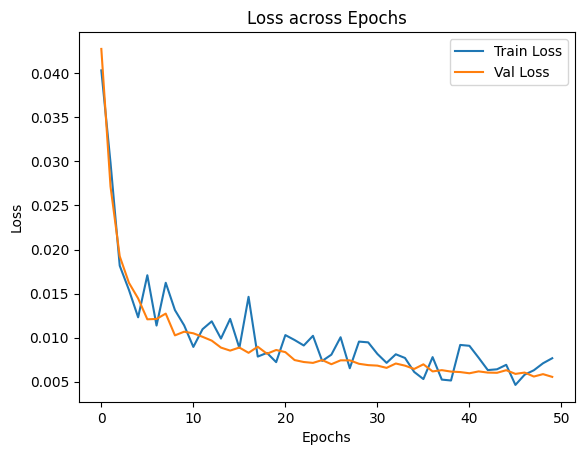

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9598445595854922


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.74%


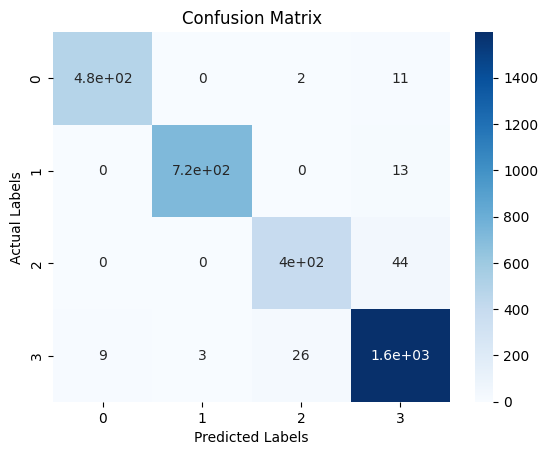

In [9]:
encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'

# Model for Left Hand
tag = '1CNN_1LSTM_UD_Larm'

# Train and save Autoencoder
train_losses, val_losses = train_model(Autoencoder, train_dataloader_L, val_dataloader_L, val_dataset_L, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
plot_loss_graph(train_losses, val_losses, tag)

# Load Encoder, Encode data
encoded_data, labels = encode_data(train_dataloader_L, dataset_ver, tag, encoder_ver)

# Train SVM
svm_classifier = train_svm(encoded_data, labels.ravel(), dataset_ver, tag, encoder_ver)
test_labels, test_predictions = test_model(test_dataloader_L, dataset_ver, tag, encoder_ver)
calculate_accuracy(test_labels, test_predictions, tag)

In [10]:
# Model for Right Hand
# tag = '1CNN_1LSTM_UD_Rarm'

# # Train and save Autoencoder
# train_losses, val_losses = train_model(Autoencoder, train_dataloader_R, val_dataloader_R, val_dataset_R, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
# plot_loss_graph(train_losses, val_losses, tag)

# # Load Encoder, Encode data
# encoded_data, labels = encode_data(train_dataloader_R, dataset_ver, tag, encoder_ver)

# # Train SVM
# svm_classifier = train_svm(encoded_data, labels.ravel(), dataset_ver, tag, encoder_ver)
# test_labels, test_predictions = test_model(test_dataloader_R, dataset_ver, tag, encoder_ver)
# calculate_accuracy(test_labels, test_predictions, tag)